In [1]:
!pip install pystan

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
!pip install prophet

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 8.9 MB 5.0 MB/s 
     |████████████████████████████████| 69 kB 7.1 MB/s 
     |████████████████████████████████| 179 kB 35.7 MB/s 
     |████████████████████████████████| 45 kB 2.9 MB/s 
  Attempting uninstall: holidays
    Found existing installation: holidays 0.10.5.2
    Uninstalling holidays-0.10.5.2:
      Successfully uninstalled holidays-0.10.5.2
  Attempting uninstall: cmdstanpy
    Found existing installation: cmdstanpy 0.9.5
    Uninstalling cmdstanpy-0.9.5:
      Successfully uninstalled cmdstanpy-0.9.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
fbprophet 0.7.1 requires cmdstanpy==0.9.5, but you have cmdstanpy 1.0.1 which is incompatible.


<h1>Cài đặt thư viện

Đầu tiên, ta thêm thư viện pandas, numpy và Prophet. 

In [3]:
import pandas as pd
from fbprophet import Prophet
from fbprophet.plot import add_changepoints_to_plot

Thêm thư viện tắt thông báo

In [4]:
import warnings
warnings.simplefilter('ignore')

Thêm thư viện đọc dữ liệu của Google Drive

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
import numpy as np
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error

<h1>Đọc dữ liệu</h1>
Đầu vào của Prophet luôn là một tập dữ liệu với hai thuộc tính là ds và y. trong đó, ds có định dạng ngày, đánh dấu mốc thời gian. Và cột y đại diện cho giá trị định lượng, đại diện cho phép đo mà ta dự đoán.

In [7]:
train_XRP = pd.read_csv("/content/drive/My Drive/Năm 3/Làm nhóm HK2 2021 - 2022/Cá nhân/More/SF/Dataset/Data/7_3/xrp/xrp_train_7_3.csv", parse_dates=True, index_col=0)
train_XRP.head(5)

,Open,High,Low,Close,Volume,Currency
Date,,,,,,
2020-06-01,0.20254,0.21184,0.20132,0.21090,1662996864,USD
2020-06-02,0.21090,0.21452,0.19826,0.20317,2046863744,USD
2020-06-03,0.20316,0.20475,0.20104,0.20411,1226735360,USD
2020-06-04,0.20411,0.20713,0.20121,0.20438,1357705728,USD
2020-06-05,0.20438,0.20567,0.20174,0.20282,1165720704,USD


In [8]:
train = train_XRP[["Close"]]
train.head(5)

,Close
Date,
2020-06-01,0.21090
2020-06-02,0.20317
2020-06-03,0.20411
2020-06-04,0.20438
2020-06-05,0.20282


In [9]:
train = train.reset_index(level=0)
train.columns = ['ds','y']
train.head(5)

,ds,y
0,2020-06-01,0.21090
1,2020-06-02,0.20317
2,2020-06-03,0.20411
3,2020-06-04,0.20438
4,2020-06-05,0.20282


In [10]:
test_XRP = pd.read_csv("/content/drive/My Drive/Năm 3/Làm nhóm HK2 2021 - 2022/Cá nhân/More/SF/Dataset/Data/7_3/xrp/xrp_test_7_3.csv", parse_dates=True, index_col=0)
test_XRP.head(5)

,Open,High,Low,Close,Volume,Currency
Date,,,,,,
2021-10-26,1.09527,1.15926,1.09314,1.10674,589658624,USD
2021-10-27,1.10671,1.12462,0.95469,0.99349,1345884928,USD
2021-10-28,0.99358,1.08086,0.98220,1.05793,906768832,USD
2021-10-29,1.05806,1.09004,1.05521,1.08098,484843744,USD
2021-10-30,1.08107,1.11542,1.06318,1.08406,479639840,USD


In [11]:
test = test_XRP[["Close"]]
test.head(5)

,Close
Date,
2021-10-26,1.10674
2021-10-27,0.99349
2021-10-28,1.05793
2021-10-29,1.08098
2021-10-30,1.08406


In [12]:
test = test.reset_index(level=0)
test.columns = ['ds','y']
test.tail(5)

,ds,y
214,2022-05-28,0.38637
215,2022-05-29,0.38910
216,2022-05-30,0.41859
217,2022-05-31,0.42156
218,2022-06-01,0.39802


In [13]:
df = pd.concat([train, test],    # Combine vertically
                          ignore_index = True,
                          sort = False)
df.head(5)    

,ds,y
0,2020-06-01,0.21090
1,2020-06-02,0.20317
2,2020-06-03,0.20411
3,2020-06-04,0.20438
4,2020-06-05,0.20282


In [14]:
df.tail(5)    

,ds,y
726,2022-05-28,0.38637
727,2022-05-29,0.38910
728,2022-05-30,0.41859
729,2022-05-31,0.42156
730,2022-06-01,0.39802


<h1>Trực quan hóa dữ liệu

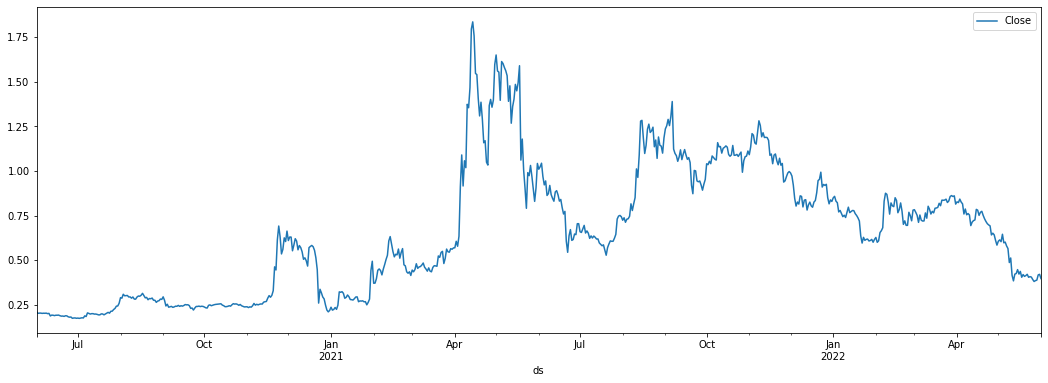

In [15]:
df.plot(x="ds", y='y',figsize=(18,6), label="Close")

<li>Ta xây dựng mô hình thông qua hàm Prophet()

In [16]:
interrupt = len(train)
interrupt

512

In [17]:
# Check size
print(train.shape)  
print(test.shape)  

(512, 2)
(219, 2)


In [18]:
future = df.copy()

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


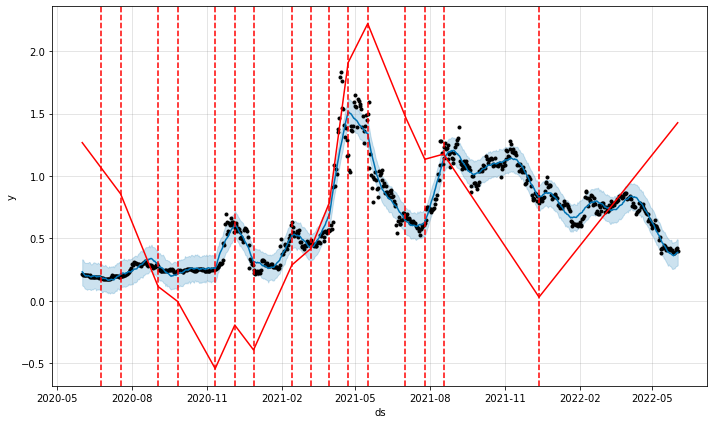

In [19]:
m = Prophet(changepoint_prior_scale=.99)
forecast = m.fit(df).predict(future)
fig = m.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), m, forecast)

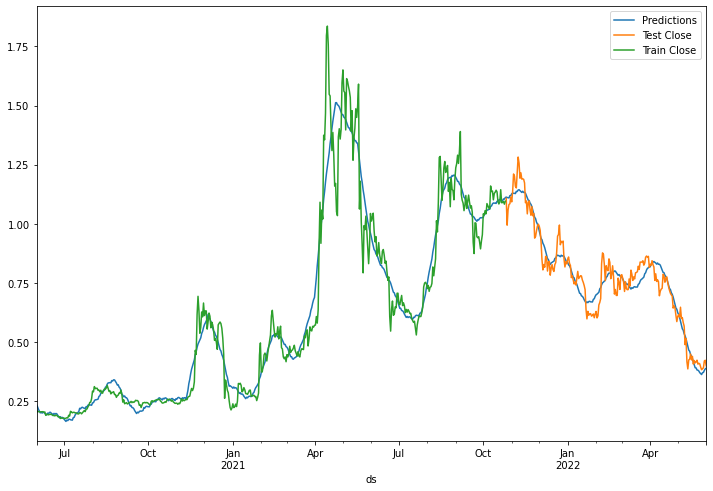

In [20]:
ax = forecast.plot(x='ds',y='yhat',label='Predictions',legend=True,figsize=(12,8))
test.plot(x='ds',y='y',label='Test Close',legend=True,ax=ax)
train.plot(x='ds',y='y',label='Train Close',legend=True,ax=ax)
#,xlim=((datetime.strptime(current_time, '%Y-%m-%d') - timedelta(days = 30)).strftime("%Y-%m-%d"),current_time)

In [21]:
mae = mean_absolute_error(test.y, forecast[interrupt:].yhat)
mape = mean_absolute_percentage_error(test.y, forecast[interrupt:].yhat)
mse = mean_squared_error(test.y, forecast[interrupt:].yhat)
rmse = np.sqrt(mse)
r2 = r2_score(test.y, forecast[interrupt:].yhat)
# print(f"MAE: {mae:.2f}")
print(f"MAPE: {mape*100:.2f}%")
# print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R2: {r2:.2f}")

MAPE: 5.66%
RMSE: 0.05
R2: 0.93
